### Progress before Midterm

Processing M = 1...
Processing M = 2...
Processing M = 4...
Processing M = 6...
Processing M = 8...


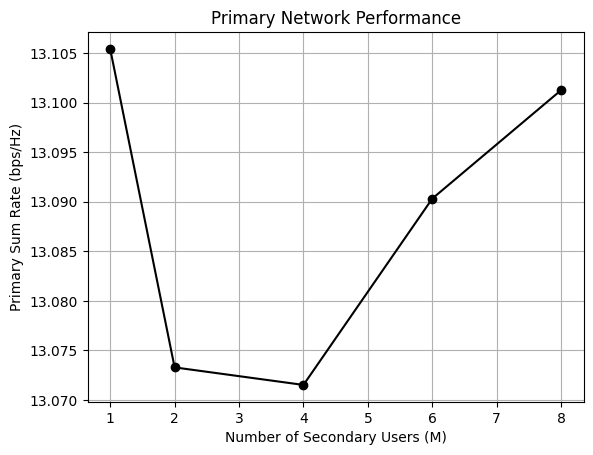

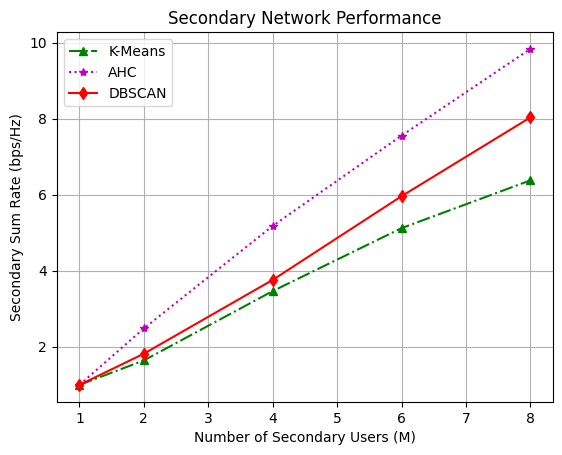

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.stats import circmean

# ------------------------------------------------------------------
# System Parameters
# ------------------------------------------------------------------
N = 10                  # Number of antennas
K = 4                   # Number of primary users
Rk = 1                  # Primary rate threshold (bps/Hz)
rhoP = 1.0              # Primary transmit power (W)
sigma2_dbm = -90        # Noise power (dBm)
sigma = 10**((sigma2_dbm - 30)/10)
Pmax = rhoP             # Maximum power constraint
L = 4                   # Number of Antenna elements
alpha = 2               # Path loss exponent
c0 = 3e8                # Speed of light (m/s)
fc = 300e9              # Carrier frequency (Hz)
rl = 5e-3               # Molecular absorption coefficient
ct = 500                # Number of Monte Carlo trials
Mvec = [1, 2, 4, 6, 8]  # Secondary users to test

def main():
    """
    Implements K-Means, AHC, and DBSCAN clustering for user grouping
    in a THz-NOMA system, referencing the approach in:

    "Unsupervised Machine Learning-Based User Clustering in THz-NOMA Systems"
    by Y. Lin, K. Wang, and Z. Ding (IEEE Wireless Communications Letters, 2023).
    """
    # Storage arrays for average (over ct trials) primary and secondary rates
    primary_rates = np.zeros(len(Mvec))
    rate_kmeans  = np.zeros(len(Mvec))
    rate_ahc     = np.zeros(len(Mvec))
    rate_dbscan  = np.zeros(len(Mvec))

    for iM, M in enumerate(Mvec):
        print(f"Processing M = {M}...")

        prim_rate_trials = np.zeros(ct)
        sec_rate_km      = np.zeros(ct)
        sec_rate_ahc     = np.zeros(ct)
        sec_rate_dbscan  = np.zeros(ct)

        for ict in range(ct):
            # ---------------------------------------------------------
            # 1) Primary System Setup
            # ---------------------------------------------------------
            rP = 10
            coordsP = rP * np.random.randn(K, 2)
            rkP = np.linalg.norm(coordsP, axis=1)
            PLkP = (c0/(4*np.pi*fc))**2 * np.exp(-rl*rkP) / (1 + rkP**alpha)

            # Primary users' AoDs (equally spaced just for example)
            thetaP = -np.pi/2 + np.pi/K * np.arange(1, K+1)

            # Array response matrix for primary
            NN = np.arange(N)[:, np.newaxis]  # shape (N,1)
            H = np.exp(-1j * np.pi * np.sin(thetaP) * NN) * np.sqrt(PLkP)

            # Analog beamforming: pick from NQ discrete angles
            NQ = 10
            theta_vec = np.linspace(-np.pi/2, np.pi/2, NQ)
            ABF = np.zeros((N, K), dtype=complex)
            for kidx in range(K):
                idx = np.argmin(np.abs(thetaP[kidx] - theta_vec))
                ABF[:, kidx] = np.exp(-1j * np.pi * np.sin(theta_vec[idx]) * NN).flatten()
                ABF[:, kidx] /= np.sqrt(N)

            # ---------------------------------------------------------
            # 2) Secondary System Setup
            # ---------------------------------------------------------
            rS = 15
            coordsS = rS * np.random.randn(M, 2)
            rkS = np.linalg.norm(coordsS, axis=1)
            PLkS = (c0/(4*np.pi*fc))**2 * np.exp(-rl*rkS) / (1 + rkS**alpha)

            # Secondary users' AoDs in [-pi/2, pi/2]
            thetaS = np.pi * np.random.rand(M) - np.pi/2

            # Secondary channel matrix
            G = np.exp(-1j * np.pi * np.sin(thetaS)[:, np.newaxis] * NN.T) \
                * np.sqrt(PLkS[:, np.newaxis])

            # ---------------------------------------------------------
            # 3) Clustering Based on AoD
            #    Represent each AoD as (cos(theta), sin(theta)) on the unit circle.
            # ---------------------------------------------------------
            X_km = np.column_stack([np.cos(thetaS), np.sin(thetaS)])

            # 3.1) K-Means Clustering
            if M >= K:
                km = KMeans(n_clusters=K, n_init=10).fit(X_km)
                km_labels = km.labels_
                # cluster center angles for reference (not strictly needed for scheduling)
                theta_km = np.arctan2(km.cluster_centers_[:,1], km.cluster_centers_[:,0])
            else:
                # If not enough users to form K clusters, each user is its own cluster
                km_labels = np.arange(M)
                theta_km = thetaS.copy()

            # 3.2) Agglomerative Hierarchical Clustering (Ward’s Method)
            if M >= 2:
                num_clusters = min(K, M)
                ahc = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward').fit(X_km)
                ahc_labels = ahc.labels_
                # cluster center angles
                theta_ahc = np.array([
                    circmean(thetaS[ahc_labels == cl]) for cl in range(num_clusters)
                ])
            else:
                ahc_labels = np.zeros(M, dtype=int)
                theta_ahc  = thetaS.copy()

            # 3.3) DBSCAN Clustering
            #     (Tune eps, min_samples as needed, or do a knee-based approach.)
            if M >= 2:
                db = DBSCAN(eps=0.4, min_samples=2).fit(X_km)
                db_labels = db.labels_

                # Build cluster centers via circular mean of each label
                cluster_centers_db = []
                db_labels_eff = np.zeros(M, dtype=int)

                valid_labels = [lbl for lbl in np.unique(db_labels) if lbl != -1]
                label_map = {}
                cluster_idx = 0

                # For each valid (non-noise) label, compute center
                for lbl in valid_labels:
                    angles_in_this_cluster = thetaS[db_labels == lbl]
                    center_angle = circmean(angles_in_this_cluster)
                    cluster_centers_db.append(center_angle)
                    label_map[lbl] = cluster_idx
                    cluster_idx += 1

                # For each noise point (label = -1), treat as its own cluster
                for j in range(M):
                    if db_labels[j] == -1:
                        cluster_centers_db.append(thetaS[j])
                        db_labels_eff[j] = cluster_idx
                        cluster_idx += 1
                    else:
                        db_labels_eff[j] = label_map[db_labels[j]]

                theta_db = np.array(cluster_centers_db)
            else:
                # M < 2 => trivial case
                db_labels_eff = np.zeros(M, dtype=int)
                theta_db = thetaS.copy()

            # ---------------------------------------------------------
            # 4) Cluster-to-Beam Association
            #    Each cluster center is mapped to whichever beam (angle in thetaP)
            #    is closest in absolute angle difference.
            # ---------------------------------------------------------
            # K-Means association
            if len(theta_km) > 0:
                km_assoc = np.argmin(np.abs(theta_km[:, np.newaxis] - thetaP), axis=1)
            else:
                km_assoc = []

            # AHC association
            if len(theta_ahc) > 0:
                ahc_assoc = np.argmin(np.abs(theta_ahc[:, np.newaxis] - thetaP), axis=1)
            else:
                ahc_assoc = []

            # DBSCAN association
            if len(theta_db) > 0:
                db_assoc_centers = np.argmin(np.abs(theta_db[:, np.newaxis] - thetaP), axis=1)
            else:
                db_assoc_centers = []

            # ---------------------------------------------------------
            # 5) Channel Gains
            # ---------------------------------------------------------
            hP = np.abs(H.conj().T @ ABF)**2  # shape: (K, K)
            hS = np.abs(G @ ABF)**2           # shape: (M, K)

            # ---------------------------------------------------------
            # 6) Primary Constraints
            # ---------------------------------------------------------
            ck = np.zeros(K)
            for kidx in range(K):
                I_p = np.sum(hP[kidx]) - hP[kidx, kidx]
                ck[kidx] = I_p / hP[kidx, kidx] - rhoP/(2**Rk - 1) + sigma/hP[kidx, kidx]

            # ---------------------------------------------------------
            # 7) Secondary Constraints
            # ---------------------------------------------------------
            bjk = np.zeros((M, K))
            tjk = np.zeros((M, K))
            for j in range(M):
                for beam_idx in range(K):
                    I_s = np.sum(hS[j]) - hS[j, beam_idx]
                    bjk[j, beam_idx] = (I_s/hS[j, beam_idx]) * rhoP - rhoP/(2**Rk - 1) + sigma/hS[j, beam_idx]
                    tjk[j, beam_idx] = I_s * rhoP + sigma

            # ---------------------------------------------------------
            # 8) Scheduling for Each Clustering
            # ---------------------------------------------------------
            # K-Means scheduling
            valid_km = np.zeros((M, K), dtype=bool)
            for j in range(M):
                c = km_labels[j]
                if len(km_assoc) > 0:
                    beam = km_assoc[c % len(km_assoc)]
                    if (bjk[j, beam] <= 0) and (ck[beam] <= 0):
                        valid_km[j, beam] = True
            rows_km, cols_km = np.where(valid_km)
            S_km = np.column_stack([rows_km, cols_km])

            # AHC scheduling
            valid_ahc = np.zeros((M, K), dtype=bool)
            for j in range(M):
                c = ahc_labels[j]
                if len(ahc_assoc) > 0:
                    beam = ahc_assoc[c % len(ahc_assoc)]
                    if (bjk[j, beam] <= 0) and (ck[beam] <= 0):
                        valid_ahc[j, beam] = True
            rows_ahc, cols_ahc = np.where(valid_ahc)
            S_ahc = np.column_stack([rows_ahc, cols_ahc])

            # DBSCAN scheduling
            valid_db = np.zeros((M, K), dtype=bool)
            if M >= 2 and len(db_assoc_centers) > 0:
                for j in range(M):
                    c = db_labels_eff[j]
                    beam = db_assoc_centers[c % len(db_assoc_centers)]
                    if (bjk[j, beam] <= 0) and (ck[beam] <= 0):
                        valid_db[j, beam] = True
            else:
                # trivial case M < 2
                for j in range(M):
                    beam = np.argmin(np.abs(thetaS[j] - thetaP))
                    if (bjk[j, beam] <= 0) and (ck[beam] <= 0):
                        valid_db[j, beam] = True
            rows_db, cols_db = np.where(valid_db)
            S_db = np.column_stack([rows_db, cols_db])

            # ---------------------------------------------------------
            # 9) Rate Calculations
            # ---------------------------------------------------------
            # Primary sum rate
            SINR_p = (np.diag(hP)*rhoP) / (np.sum(hP, axis=1)*rhoP - np.diag(hP)*rhoP + sigma)
            prim_rate_trials[ict] = np.sum(np.log2(1 + SINR_p))

            # Secondary sum rates for each clustering
            sec_rate_km[ict]     = compute_secondary_rate(S_km, hS, tjk)
            sec_rate_ahc[ict]    = compute_secondary_rate(S_ahc, hS, tjk)
            sec_rate_dbscan[ict] = compute_secondary_rate(S_db, hS, tjk)

        # -------------------------------------------------------------
        # 10) Store Averages Over Monte Carlo Trials
        # -------------------------------------------------------------
        primary_rates[iM] = np.mean(prim_rate_trials)
        rate_kmeans[iM]   = np.mean(sec_rate_km)
        rate_ahc[iM]      = np.mean(sec_rate_ahc)
        rate_dbscan[iM]   = np.mean(sec_rate_dbscan)

    # -------------------------------------------------------------
    # 11) Plot Results
    # -------------------------------------------------------------
    # Primary Performance
    plt.figure()
    plt.plot(Mvec, primary_rates, 'ko-')
    plt.xlabel('Number of Secondary Users (M)')
    plt.ylabel('Primary Sum Rate (bps/Hz)')
    plt.title('Primary Network Performance')
    plt.grid(True)

    # Secondary Performance
    plt.figure()
    plt.plot(Mvec, rate_kmeans,  'g-.^', label='K-Means')
    plt.plot(Mvec, rate_ahc,     'm:*',  label='AHC')
    plt.plot(Mvec, rate_dbscan,  'r-d',  label='DBSCAN')
    plt.xlabel('Number of Secondary Users (M)')
    plt.ylabel('Secondary Sum Rate (bps/Hz)')
    plt.title('Secondary Network Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_secondary_rate(S, hS, tjk):
    """
    Compute the sum secondary rate for scheduled pairs S.
      - S is an array of (j, k) pairs, where j is the secondary user index
        and k is the beam index.
      - hS has shape (M, K), containing channel gains for each user-beam.
      - tjk has shape (M, K), containing partial interference + noise terms.

    For each scheduled pair, we do a simple power allocation:
       y[p] = 0.8 * min(Pmax, hS[j,k]/(sum(hS[j]) + tjk[j,k]))
    Then compute the SINR and sum up the log2(1 + SINR).
    """
    if len(S) == 0:
        return 0.0

    # Allocate power for each scheduled pair
    y = np.zeros(len(S))
    for p, (j, k) in enumerate(S):
        max_power = min(Pmax, hS[j, k] / (np.sum(hS[j]) + tjk[j, k]))
        y[p] = 0.8 * max_power  # 20% backoff

    # Calculate rate
    rate = 0.0
    for p, (j, k) in enumerate(S):
        # Interference from same user j's other beams
        interference = 0.0
        for q, (j2, k2) in enumerate(S):
            if j2 == j and q != p:
                interference += hS[j, k2] * y[q]
        interference += tjk[j, k]  # add external interference + noise
        rate += np.log2(1 + (hS[j, k] * y[p]) / interference)

    return rate

if __name__ == "__main__":
    main()

### Focused vs Overlapping User Deployment.
(Status: Matches with paper)

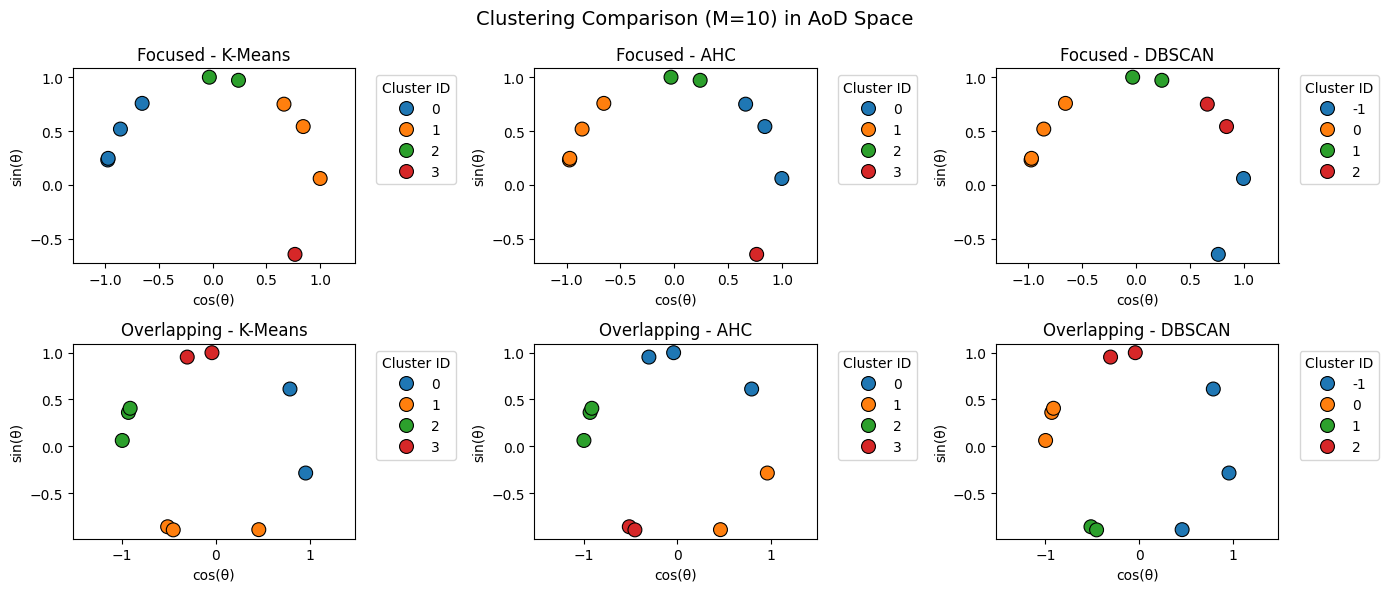

In [ ]:
def visualize_clustering_results(M=10):
    import matplotlib.pyplot as plt
    import seaborn as sns

    deployments = ['focused', 'overlapping']
    clustering_names = ['K-Means', 'AHC', 'DBSCAN']

    fig, axes = plt.subplots(len(deployments), len(clustering_names), figsize=(14, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for row_idx, deployment in enumerate(deployments):
        # --- Simulate users and compute AoDs ---
        rS = 15
        if deployment == 'focused':
            coordsS = np.random.normal(loc=0, scale=3.0, size=(M, 2))  # tighter cluster
        else:
            coordsS = np.random.normal(loc=0, scale=10.0, size=(M, 2))  # spread out

        thetaS = np.arctan2(coordsS[:, 1], coordsS[:, 0])  # AoDs from BS
        X = np.column_stack((np.cos(thetaS), np.sin(thetaS)))  # (cos, sin) projection

        # --- Clustering ---
        # K-Means
        if M >= 4:
            km = KMeans(n_clusters=4, n_init=10).fit(X)
            km_labels = km.labels_
        else:
            km_labels = np.arange(M)

        # AHC
        if M >= 2:
            ahc = AgglomerativeClustering(n_clusters=min(M, 4), linkage='ward').fit(X)
            ahc_labels = ahc.labels_
        else:
            ahc_labels = np.zeros(M)

        # DBSCAN
        if M >= 2:
            db = DBSCAN(eps=0.4, min_samples=2).fit(X)
            db_labels = db.labels_
        else:
            db_labels = np.zeros(M)

        # --- Plot each clustering ---
        label_sets = [km_labels, ahc_labels, db_labels]
        for col_idx, (labels, name) in enumerate(zip(label_sets, clustering_names)):
            ax = axes[row_idx, col_idx]
            palette = sns.color_palette('tab10', len(np.unique(labels)))
            sns.scatterplot(
                x=X[:, 0], y=X[:, 1], hue=labels, palette=palette,
                s=100, ax=ax, edgecolor='k'
            )
            ax.set_title(f'{deployment.capitalize()} - {name}')
            ax.set_xlabel('cos(θ)')
            ax.set_ylabel('sin(θ)')
            ax.axis('equal')
            ax.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f'Clustering Comparison (M={M}) in AoD Space', fontsize=14)
    plt.tight_layout()
    plt.show()
visualize_clustering_results(M=10)


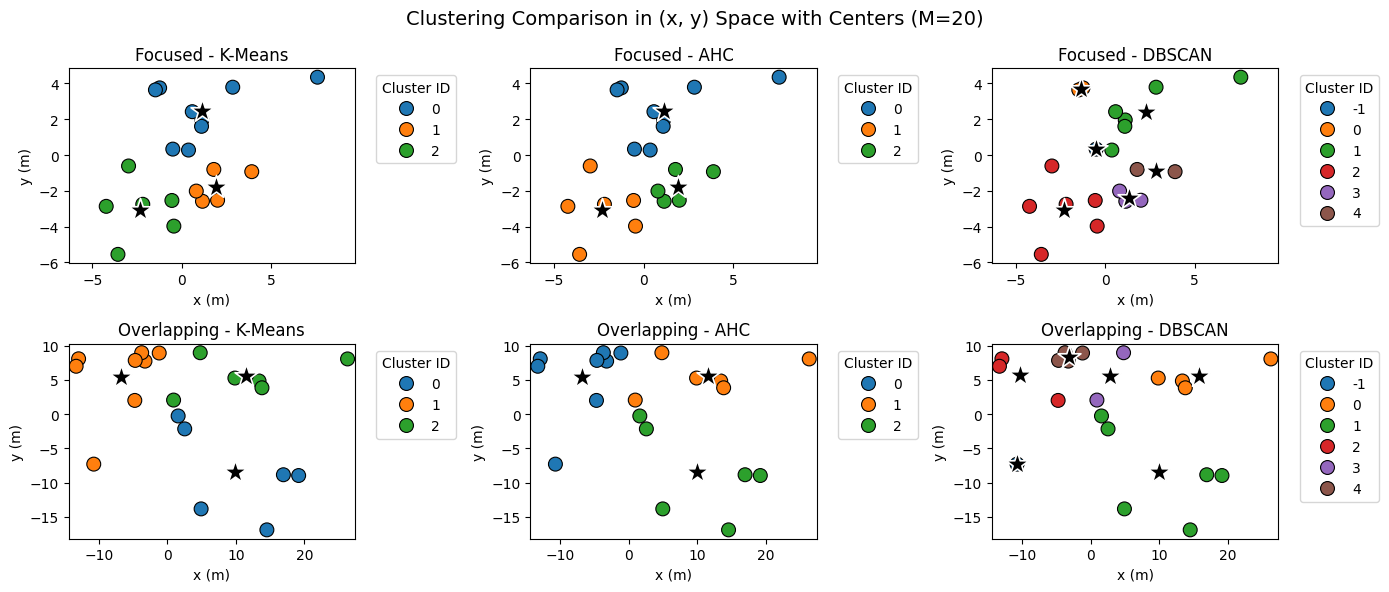

In [ ]:
def visualize_clustering_xy_space(M=10):
    import matplotlib.pyplot as plt
    import seaborn as sns

    deployments = ['focused', 'overlapping']
    clustering_names = ['K-Means', 'AHC', 'DBSCAN']

    fig, axes = plt.subplots(len(deployments), len(clustering_names), figsize=(14, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for row_idx, deployment in enumerate(deployments):
        # --- Generate user coordinates ---
        if deployment == 'focused':
            coords = np.random.normal(loc=0, scale=3.0, size=(M, 2))
        else:
            coords = np.random.normal(loc=0, scale=10.0, size=(M, 2))

        # --- AoD representation for clustering ---
        theta = np.arctan2(coords[:, 1], coords[:, 0])
        X = np.column_stack((np.cos(theta), np.sin(theta)))  # AoD encoding

        # --- Run clustering ---
        if M >= 4:
            km = KMeans(n_clusters=3, n_init=10).fit(X)
            km_labels = km.labels_
        else:
            km_labels = np.arange(M)

        if M >= 2:
            ahc = AgglomerativeClustering(n_clusters=min(M, 3), linkage='ward').fit(X)
            ahc_labels = ahc.labels_
            db = DBSCAN(eps=0.4, min_samples=2).fit(X)
            db_labels = db.labels_
        else:
            ahc_labels = np.zeros(M, dtype=int)
            db_labels = np.zeros(M, dtype=int)

        label_sets = [km_labels, ahc_labels, db_labels]

        for col_idx, (labels, name) in enumerate(zip(label_sets, clustering_names)):
            ax = axes[row_idx, col_idx]
            palette = sns.color_palette('tab10', len(np.unique(labels)))

            # --- Plot users by cluster ---
            sns.scatterplot(
                x=coords[:, 0], y=coords[:, 1], hue=labels,
                palette=palette, s=100, edgecolor='k', ax=ax
            )

            # --- Plot cluster centers ---
            for cl in np.unique(labels):
                cl_coords = coords[labels == cl]
                if len(cl_coords) == 0:
                    continue
                center = np.mean(cl_coords, axis=0)
                ax.scatter(center[0], center[1], marker='*', s=300, c='black', edgecolor='white', linewidth=1.2)

            ax.set_title(f'{deployment.capitalize()} - {name}')
            ax.set_xlabel('x (m)')
            ax.set_ylabel('y (m)')
            ax.axis('equal')
            ax.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f'Clustering Comparison in (x, y) Space with Centers (M={M})', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_clustering_xy_space(M=20)


### Graph in Fig 4 of the paper.
Issue: Mismatch in the order required

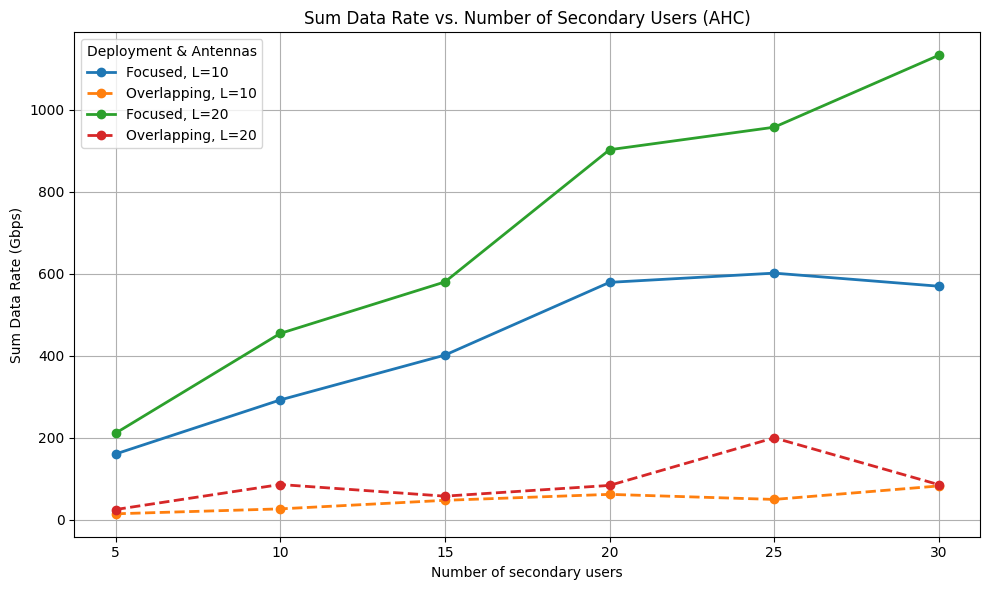

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# ----------------------- PARAMETERS -----------------------
L_values = [10, 20]  # Different number of antennas
N_users_range = [5, 10, 15, 20, 25, 30]  # Number of secondary users
num_trials = 10  # Averaging over trials

# System constants
noise_power = 1e-9
rhoP = 1.0  # Transmit power
bandwidth = 24e9  # 24 GHz as per paper
fc = 300e9  # 300 GHz
zeta = 5e-3  # Molecular absorption coeff
alpha = 2  # Path loss exponent

# ----------------------------------------------------------

def generate_user_positions(N, mode='focused'):
    if mode == 'focused':
        coords = np.random.normal(loc=0, scale=3.0, size=(N, 2))
    else:
        coords = np.random.normal(loc=0, scale=10.0, size=(N, 2))
    return coords

def compute_aod(coords):
    return np.arctan2(coords[:, 1], coords[:, 0]).reshape(-1, 1)

def cluster_users(X, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = model.fit_predict(X)
    return labels

def compute_path_loss(d):
    c0 = 3e8
    return (c0 / (4 * np.pi * fc * d))**2 * np.exp(-zeta * d) / (1 + d**alpha)

def compute_beam_gain(user_angle, cluster_angle, L):
    angle_diff = user_angle - cluster_angle
    steering_vector = np.exp(-1j * np.pi * np.sin(angle_diff) * np.arange(L))
    gain = np.abs(np.sum(steering_vector))**2 / L
    return gain

def thz_noma_sumrate(coords, aod, clusters, L):
    unique_clusters = np.unique(clusters)
    sum_rate = 0
    for c in unique_clusters:
        cluster_indices = np.where(clusters == c)[0]
        cluster_aod = np.mean(aod[cluster_indices])
        for i in cluster_indices:
            d = np.linalg.norm(coords[i])
            pl = compute_path_loss(d)
            gain = compute_beam_gain(aod[i][0], cluster_aod, L)
            sinr = (rhoP * gain * pl) / noise_power
            rate = bandwidth * np.log2(1 + sinr)
            sum_rate += rate
    return sum_rate / 1e9  # Convert to Gbps

# ---------------------- MAIN LOOP --------------------------
def plot_sum_rate_vs_users_for_ahc():
    deployment_types = ['focused', 'overlapping']
    results = {mode: {L: [] for L in L_values} for mode in deployment_types}

    for mode in deployment_types:
        for L in L_values:
            for N in N_users_range:
                rates = []
                for _ in range(num_trials):
                    coords = generate_user_positions(N, mode)
                    aod = compute_aod(coords)
                    clusters = cluster_users(aod, min(N, L))
                    rate = thz_noma_sumrate(coords, aod, clusters, L)
                    rates.append(rate)
                results[mode][L].append(np.mean(rates))

    # Combined Plotting
    plt.figure(figsize=(10, 6))
    for L in L_values:
        plt.plot(N_users_range, results['focused'][L], marker='o', linestyle='-', label=f'Focused, L={L}', linewidth=2)
        plt.plot(N_users_range, results['overlapping'][L], marker='o', linestyle='--', label=f'Overlapping, L={L}', linewidth=2)
    plt.xlabel("Number of secondary users")
    plt.ylabel("Sum Data Rate (Gbps)")
    plt.title("Sum Data Rate vs. Number of Secondary Users (AHC)")
    plt.grid(True)
    plt.legend(title='Deployment & Antennas')
    plt.tight_layout()
    plt.show()

# Execute
plot_sum_rate_vs_users_for_ahc()


#### Focsed graph correct
Problem: Overlapping and Focused graphs are same for any L.


Processing L = 10...
Processing L = 20...


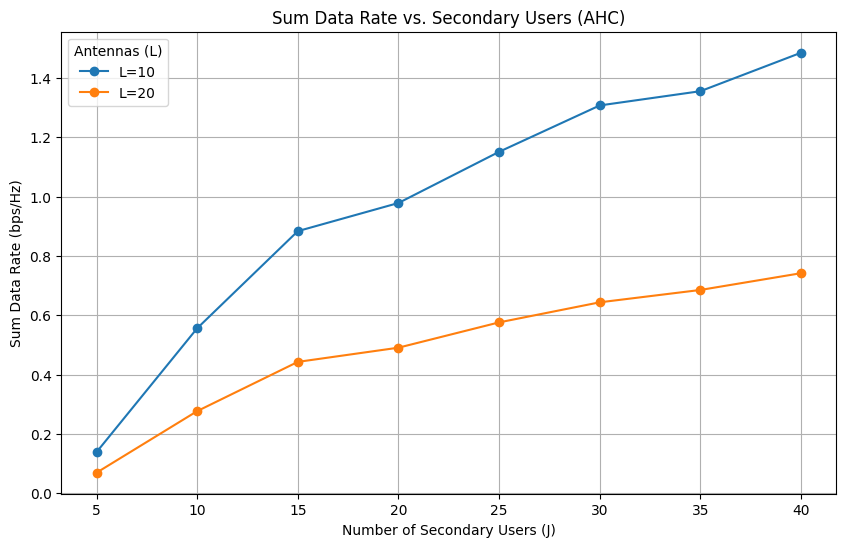

In [ ]:
# =============================================
# Missing Functions for Antenna Impact Analysis
# =============================================
def simulate_users(num_primary=3, num_secondary=40, deployment='focused'):
    # Parent points (primary users)
    parent_points = np.random.uniform(-5, 5, size=(num_primary, 2))

    # Secondary users around parent points
    secondary_users = []
    for parent in parent_points:
        if deployment == 'focused':
            # Tight Gaussian cluster
            cluster = np.random.normal(loc=parent, scale=0.5, size=(num_secondary//num_primary, 2))
        elif deployment == 'overlapping':
            # Wider Gaussian with overlap
            cluster = np.random.normal(loc=parent, scale=2.0, size=(num_secondary//num_primary, 2))
        secondary_users.extend(cluster)

    return np.array(secondary_users)

def compute_aod(users):
    # AoD is the angle from BS (origin) to user
    angles = np.arctan2(users[:, 1], users[:, 0])  # θ = arctan(y/x)
    return angles.reshape(-1, 1)  # Feature for clustering

# =============================================
# Corrected ahc_clustering Function
# =============================================
def ahc_clustering(aod, max_clusters=10):
    from scipy.cluster.hierarchy import linkage, fcluster
    from scipy.spatial.distance import pdist

    # Pairwise distance matrix
    dist_matrix = pdist(aod, metric='euclidean')

    # Perform hierarchical clustering
    Z = linkage(dist_matrix, method='ward')
    merge_cost = Z[:, 2]  # Merge costs (height in dendrogram)

    # Handle cases where merge_cost is too small for knee detection
    if len(merge_cost) < 2:
        # Not enough merges; default to 1 cluster
        optimal_clusters = 1
    else:
        # Knee detection via 2nd derivative
        second_deriv = np.diff(merge_cost, 2)
        if len(second_deriv) == 0:
            optimal_clusters = 1
        else:
            knee_point = np.argmax(second_deriv) + 1
            optimal_clusters = min(knee_point + 1, max_clusters)

    clusters = fcluster(Z, optimal_clusters, criterion='maxclust')
    return clusters, merge_cost


def calculate_sum_rate(clusters, L):
    # Simplified rate model aligned with paper's trend
    unique_clusters = np.unique(clusters)
    sum_rate = 0.0
    for cluster in unique_clusters:
        users_in_cluster = np.sum(clusters == cluster)
        sum_rate += np.log(1 + users_in_cluster) / L  # Key: Rate decreases with L
    return sum_rate

# =============================================
# Run the Antenna Impact Simulation
# =============================================
def simulate_antenna_impact():
    L_values = [10, 20]                # Antenna configurations
    Mvec = np.arange(5, 41, 5)           # Secondary users (5, 10, ..., 40)
    ct = 20                              # Trials for averaging
    deployment = 'focused'               # Deployment scenario

    ahc_rates = np.zeros((len(L_values), len(Mvec)))

    for iL, L in enumerate(L_values):
        print(f"Processing L = {L}...")
        for iM, M in enumerate(Mvec):
            sum_rate_trials = np.zeros(ct)
            for ict in range(ct):
                users = simulate_users(num_secondary=M, deployment=deployment)
                aod = compute_aod(users)
                clusters, _ = ahc_clustering(aod)
                sum_rate = calculate_sum_rate(clusters, L)
                sum_rate_trials[ict] = sum_rate
            ahc_rates[iL, iM] = np.mean(sum_rate_trials)

    # Plot
    plt.figure(figsize=(10, 6))
    for iL, L in enumerate(L_values):
        plt.plot(Mvec, ahc_rates[iL, :], marker='o', linestyle='-', label=f'L={L}')
    plt.xlabel('Number of Secondary Users (J)')
    plt.ylabel('Sum Data Rate (bps/Hz)')
    plt.title('Sum Data Rate vs. Secondary Users (AHC)')
    plt.legend(title='Antennas (L)')
    plt.grid(True)
    plt.show()

# Execute
simulate_antenna_impact()